In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
 
import torch.nn as nn
 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
 
%matplotlib inline

#set device 
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)

In [2]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 99

# Size of feature maps in generator
ngf = 60 #MUST BE DIVISIBLE BY 3!!!

# Size of feature maps in discriminator
ndf = 64


class BigGenerator(nn.Module):
    def __init__(self):
        super(BigGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*16) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 32 x 32``
            nn.ConvTranspose2d( ngf * 1, nc * 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc * 3) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
        
class SetDiscriminator(nn.Module):
    def __init__(self):
        super(SetDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc*3) x 64 x 64``
            nn.Conv2d(nc*3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

class ImageDiscriminator(nn.Module):
    def __init__(self):
        super(ImageDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [3]:
netG = BigGenerator()
netD = SetDiscriminator()
netD_img = ImageDiscriminator()
netG = netG.to(device)
netD = netD.to(device)
netD_img = netD_img.to(device)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print('PARAM COUNT: ', get_n_params(netG), get_n_params(netD))

def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)
        
# initializing the weights
netD.apply(init_weights)
netD_img.apply(init_weights)
netG.apply(init_weights)

PARAM COUNT:  3189960 2771712


BigGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(99, 480, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(480, 240, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(240, 120, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(120, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(60, 9, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [4]:
import numpy as np
class SetDataset(Dataset):
    """set dataset."""
 
    def __init__(self, imgs_path):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.num_images = 3
        self.dict_data = np.load(imgs_path)
        self.sets_raw = self.dict_data['arr_0']
        self.sets = []

        for set_raw in self.sets_raw:
            set = np.transpose( # imp step to convert image size from (7312, 32,32,3) to (7312, 3,32,32)
                            np.float32(set_raw), # imp step to convert double -&gt; float (by default numpy input uses double as data type)
                            (0, 3,1,2) # tuple to describe how to rearrange the dimensions
                            ) 
            self.sets.append(set)
 
    def __len__(self):
        return len(self.sets)
 
    def __getitem__(self, idx):
        result_set = self.sets[idx]
        result = np.concatenate((result_set[0], result_set[1], result_set[2]), axis=0)
        return result

In [5]:
data_path = "/kaggle/input/onecircle64/oneCircle_64x64.npz"
dataset = SetDataset(data_path)

batch_size = 60
shuffle = True

 
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle)


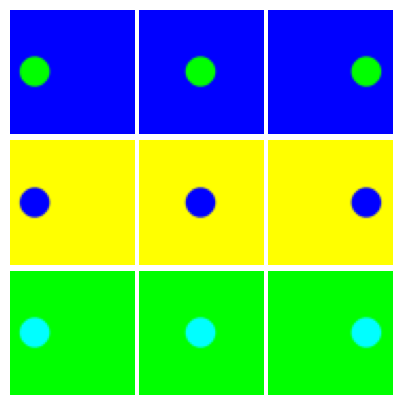

In [6]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize = (5,5))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.5, hspace=0.5) # set the spacing between axes. 
k = 1

for i in range(3):
    sample = dataset.__getitem__(np.random.randint(100))
    ax1 = plt.subplot(3,3,k)
    plt.imshow(np.transpose(sample[0:3], (1,2,0)))
    plt.axis(False)
    ax1.set_aspect('equal')
    k += 1
    ax2 = plt.subplot(3,3,k)
    plt.imshow(np.transpose(sample[3:6], (1,2,0)))
    plt.axis(False)
    ax2.set_aspect('equal')
    k += 1
    ax3 = plt.subplot(3,3,k)
    plt.imshow(np.transpose(sample[6:9], (1,2,0)))
    plt.axis(False)
    k += 1
    ax3.set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0.05)

In [7]:
filename = 'circles.png' 
fig.savefig(filename, dpi=fig.dpi)

In [8]:
def setToImgBatch(batch, batchSize = 60):
    nc = 3
    #batch has shape (batchSize, 3, 128, 128)
    b = batch.shape[0]
    if batchSize == 0:
        return torch.reshape(batch, (b * 3, nc, 64, 64))
    else:
        imgs =  torch.reshape(batch, (b * 3, nc, 64, 64))
        rand_idx = np.random.choice(b*3, batchSize)
        return imgs[rand_idx]

In [9]:
# Setting up optimizers for both Generator and Discriminator
 
opt_D= optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_D_img= optim.Adam(netD_img.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))

# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)
loss = BCELoss()
print(device)

cuda:0


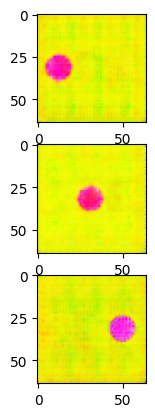

********************
 Epoch 1 and iteration 15 and iterNum 100 
gen loss 1.5907955169677734


KeyboardInterrupt: 

In [33]:
# TRAINING GANS
epochs = 60
iterNum = 0
loss_image_coef = 1
loss_set_coef = 1
beta = 1e9
# going over the entire dataset 10 times
for e in range(epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
        iterNum += 1
        ##########################
        ## Update Set Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), nz, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_set = netG(noise) # (batchsize, 9, 64, 64)

        loss_fake = 0

        # compute D model output on fake images
        yhat = netD(fake_set.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake += loss(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D.step()

        ##########################
        #### Update Generator on Set Discriminator Loss####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()


        # pass fake image through D
        yhat = netD(fake_set).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_set_coef * loss(yhat, target)
        loss_gen_set = loss_gen # for tracking
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()

        ##########################
        ## Update Image Discriminator ##
        ##########################
 
        # Loss on real images
        b_img =  setToImgBatch(b, batchSize = 60)
        # clear the gradient
        opt_D_img.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD_img(b_img.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b_img), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b_img), nz, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_set = netG(noise) # (batchsize, 3, 128, 128)
        fake_set_new = setToImgBatch(fake_set, batchSize = len(b_img))
        loss_fake = 0
        # compute D model output on fake images
        yhat = netD_img(fake_set_new.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(yhat), dtype=torch.float, device=device)
        # calculate loss
        loss_fake += loss(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D_img.step()

        ##########################
        #### Update Generator on Image Discriminator Loss####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()
        
        # pass fake image through D
        yhat = netD_img(fake_set_new).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(yhat), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_image_coef * loss(yhat, target)
        loss_gen_img = loss_gen #for tracking
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()

 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if iterNum% 100 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting
            imgs_plot = []
            sub = 1
            fake_set_sample = fake_set[0]
            img0 = np.transpose(fake_set_sample[0:3,:,:].detach().cpu(), (1, 2, 0))
            img1 = np.transpose(fake_set_sample[3:6,:,:].detach().cpu(), (1, 2, 0))
            img2 = np.transpose(fake_set_sample[6:9,:,:].detach().cpu(), (1, 2, 0))
            plt.subplot(3,1,1)
            plt.imshow(img0)
            plt.subplot(3,1,2)
            plt.imshow(img1)
            plt.subplot(3,1,3)
            plt.imshow(img2)
            plt.show()
            print("********************")
            print(" Epoch %d and iteration %d and iterNum %d " % (e, i, iterNum))
            print('gen loss', loss_gen.item())

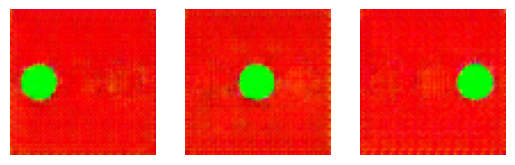

output5.png


In [41]:
noise = torch.randn(20, nz, 1, 1, device = device)
output = netG(noise)
fake_set_sample = output[0]
img0 = np.transpose(fake_set_sample[0:3,:,:].detach().cpu(), (1, 2, 0))
img1 = np.transpose(fake_set_sample[3:6,:,:].detach().cpu(), (1, 2, 0))
img2 = np.transpose(fake_set_sample[6:9,:,:].detach().cpu(), (1, 2, 0))

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img0)
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(img1)
plt.axis(False)
plt.subplot(1,3,3)
plt.imshow(img2)
plt.axis(False)
plt.show()
filename = 'output' + str(np.random.randint(100)) + '.png'
print(filename)
fig.savefig(filename, dpi=fig.dpi)

In [34]:
files = os.listdir(os.getcwd())
for f in files:
    if f.endswith('.png'):
        os.remove(f)